In [1]:
push!(LOAD_PATH, pwd())
using SIS,IM,PayloadGraph,PyPlot, Epidemics,JLD
import LightGraphs

function get_c_r(N,alpha,beta)
    return 4*alpha/(beta^2*N)
end

function get_n_n(N,alpha,beta)
    return beta/alpha*N
end

function get_alpha_beta(N,c_r,n_n)
    beta = 4.0/(c_r*n_n)
    alpha = (N*beta)/n_n
    return alpha,beta
end


f(y,alpha) = alpha.*y.^2
s(y,alpha,beta) = f(y,alpha)./y - beta
#get_y_eff(y,k) = y.*(1 + (1-y)./(y.*k))
#get_s_eff(y::Array,alpha,beta,k) = alpha*get_y_eff(y,k) - beta

function plot_schematic(n_n,c_r,N,k=N-1,plot_k=false)
    beta = 4.0/(c_r*n_n)
    alpha = (N*beta)/n_n
    y_n, y_minus,y_plus,y_p,critical_determinant = get_parameters(N,alpha,beta)



    y_range = collect(0:y_p/1000:1.9*y_p)
    figure(1)
    plot(y_range,1.0./abs(N*s(y_range,alpha,beta)),"-r",label=L"$\frac{1}{N|s(y)|}$")
    if plot_k
        plot(y_range,1.0./abs(N*get_s_eff(y_range,alpha,beta,k)),"-b",label=L"$\frac{1}{N|s(y_{eff})|}$")
    end
    plot(y_range,y_range,"-k",label=L"$y$")
    axvline(y_n,linestyle="--",label=L"$y_n$")
    axvline(y_p,linestyle="-",label=L"$y_p$")
    if y_minus > 0
        axvline(y_minus,linestyle="-.",label=L"$y_1$")
        axvline(y_plus,linestyle="-.",label=L"$y_2$")
    end
    ylim([0,1.9*y_p])
    legend(prop=Dict{Any,Any}("size"=>15),loc="upper right")
    xlabel(L"$y$",size=20)
    if plot_k
        #figure(1)
        #plot(y_range,get_s_eff(y_range,alpha,beta,k),"-b",label=L"$s_{eff}(y)$")
        #plot(y_range,s(y_range),"-r",label=L"$s(y)$")
        legend(prop=Dict{Any,Any}("size"=>20),loc="upper right")
        xlabel(L"$y$",size=20)
    end
end

function plot_schematics(N,alpha,beta,k,plot_k = false)
    im = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);
    imk = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,k) , x -> 1 + beta);

    c_r = get_c_r(N,alpha,beta)
    n_n = get_n_n(N,alpha,beta)
    pygui(true)
    close(1);close(2);close(3)
    dx = 2*n_n/N/50
    x = collect(dx:dx:2*n_n/N)
    y = IM.P_fix(im,N,x)
    yk = IM.P_fix(imk,N,x)
    figure(2,figsize=(8,5))
    plot(x,y,"-r",label=L"P_{fix}(y)")
    plot(x,yk,"-b",label=L"P_{fix}(y_{eff})")
    plot(x,x,"--k")
    xlim([0,2*n_n/N])
    y_n, y_minus, y_plus, y_p,critical_determinant = get_parameters(N,alpha,beta)
    axvline(y_n,linestyle="--",color="b",label=L"y_n")
    axvline(y_minus,linestyle="-.",color="r",label=L"y_1")
    axvline(y_plus,linestyle="-.",color="r",label=L"y_2")
    axvline(y_p,linestyle="-",color="b",label=L"y_p")
    xlabel(L"y")
    ylabel(L"P_{fix}(y)")
    legend(loc="upper left")
    title(latexstring("\$y_n = $(n_n/N), c_r = $c_r, N = $N\$"))
    #savefig("p_fix_y_n = $(n_n/N), c_r = $c_r, N = $N.png")

    figure(1,figsize=(8,5))
    plot_schematic(n_n,c_r,N,k,plot_k)
    title(latexstring("\$y_n = $(n_n/N), c_r = $c_r, N = $N\$"))

    figure(3)
    plot(x,get_s_eff(x,alpha,beta,k),"-b",label=L"$s_{eff}(y)$")
    plot(x,s(x,alpha,beta),"-r",label=L"$s(y)$")
    grid()

end

function plot_w(sizes,N,alpha,beta)

    figure(4)
    bins = logspace(log10(minimum(sizes)),log10(maximum(sizes)),150)
    word = graph_model ? "graph" : "well-mixed"
    label = latexstring("$word, \$k = $k\$")
    PyPlot.plt[:hist](sizes,log=true,bins=bins,alpha=0.2,normed=true,label=label)

    gca()[:set_xscale]("log")

    w_range = bins[15:end]#logspace(log10(4*minimum(sizes)),log10(maximum(sizes)),30)

    P_w_th_range = normed_distribution(w_range,P_w_th(w_range,s(sqrt(w_range)./N,alpha,beta)))
    P_w_th_range_eff = normed_distribution(w_range,P_w_th(w_range,get_s_eff(sqrt(w_range)./N,alpha,beta,k)))
    
    if graph_model
        plot(w_range,P_w_th_range,"-r",label=L"theory $k \to N-1$")#$P(w) \sim e^{- s(\sqrt{w})^2 w/4} w^{-3/2}/(1 + s(\sqrt{w}))$ (theory)')
        plot(w_range,P_w_th_range_eff,"-g",label=latexstring("effective theory \$k = $k\$"))#$P(w) \sim e^{- s(\sqrt{w})^2 w/4} w^{-3/2}/(1 + s(\sqrt{w}))$ (theory)')
    end
        
    xlabel(L"$w$",size=20)
    ylabel(L"$P(w)$",size=20)

    legend(loc="lower left")
    ylim([1e-10,1e1])
    grid()

end

plot_w (generic function with 1 method)

In [2]:
data_dir_path = "../data/"  #"/mnt/D/windows/MIT/classes/6/338/project/data/"


"../data/"

In [3]:
filenames = split(readall(`ls $data_dir_path`));
filenames[end-3:end]

4-element Array{SubString{ASCIIString},1}:
 "epidemics_2016-02-12T11:16:23.jld"
 "epidemics_2016-02-12T11:16:35.jld"
 "epidemics_2016-02-12T11:16:36.jld"
 "epidemics_2016-02-12T11:18:03.jld"

0.86

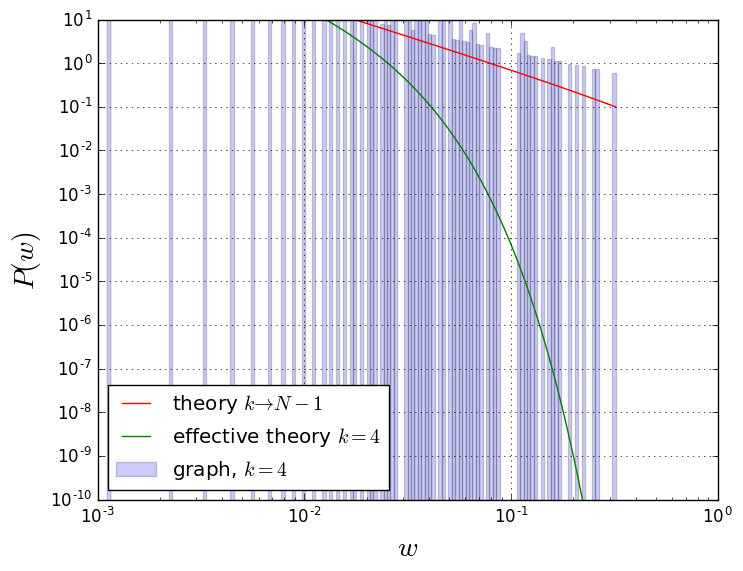

 0.7804398162272768
Is graph model: true


In [4]:
#using JLD
d = load(data_dir_path*filenames[end-2])
params = d["params"]
runs = d["runs"];
num_fixed = d["num_fixed"]
sizes = d["sizes"]

N = params["N"]
alpha = params["alpha"]
beta = params["beta"]
k = params["k"]
num_trials = length(runs)
graph_model = params["graph_model"]

c_r = get_c_r(N,alpha,beta)
n_n = get_n_n(N,alpha,beta)

#im = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);
im = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,k) , x -> 1 + beta);

y_n, y_minus, y_plus, y_p,critical_determinant = get_parameters(N,alpha,beta)

#plot_schematics(N,alpha,beta,k,true)
plot_w(sizes,N,alpha,beta)

#im = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);

println(num_fixed/num_trials," ", IM.P_fix(im,N,1/N))

println("Is graph model: $graph_model")




In [7]:
methods(get_s_eff)

# 1 method for generic function "get_s_eff":
get_s_eff(y::Array{T,N}, alpha, beta, k) at In[1]:23

In [ ]:
plot_schematics(N,alpha,beta,k,true)

In [ ]:
N = 1000
n_n = 400
c_r = 0.4
alpha,beta = get_alpha_beta(N,c_r,n_n)
plot_schematics(N,alpha,beta,k,true)
im = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,k) , x -> 1 + beta);
IM.P_fix(im,N,1/N)

In [ ]:
alpha,beta

# why are there zero fixed for the graph case?

In [ ]:
plot_w(sizes,N,alpha,beta)

In [ ]:
get_s_eff
